In [1]:
from sklearn.model_selection import train_test_split
import pickle
import os
import h5py
from PIL import Image
import numpy as np
import numpy as np
import math
import random
import transforms3d
from tensorflow.keras.layers import Rescaling, Normalization, Input, Dense, concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers

/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
2024-11-07 20:56:08.055944: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 20:56:08.068693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 20:56:08.081739: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-1

In [5]:
input_dir = r"/work/nselva2s/rnd/robile_data_corr_07112024"

In [6]:

# Define the parsing function
def _parse_with_lasers_function(proto):
    image_shape = [480, 640, 3]
    lasers_shape = 513  # Replace with the actual shape
    current_pose_shape = 3  # Replace with the actual shape
    goal_pose_shape = 3  # Replace with the actual shape
    motion_command_shape = 3  # Replace with the actual shape
    goal_shape = 2
    features = {
        'laser': tf.io.FixedLenFeature([lasers_shape], tf.float32),
        'goal': tf.io.FixedLenFeature([goal_shape], tf.float32),
        'motion_command': tf.io.FixedLenFeature([motion_command_shape], tf.float32)
    }
    parsed_features = tf.io.parse_single_example(proto, features)
    return  (parsed_features['laser'], parsed_features['goal']), parsed_features['motion_command']
    
def _parse_function_with_images_lasers(proto):
    image_shape = [480, 640, 3]  # Adjust according to your actual image shape
    lasers_shape = 513  # Replace with the actual shape
    goal_shape = 2  # Replace with the actual shape
    motion_command_shape = 3  # Replace with the actual shape

    features = {
        'image': tf.io.FixedLenFeature([], tf.string),  # Raw serialized image
        'laser': tf.io.FixedLenFeature([lasers_shape], tf.float32),
        'goal': tf.io.FixedLenFeature([goal_shape], tf.float32),
        'motion_command': tf.io.FixedLenFeature([motion_command_shape], tf.float32)
    }
    
    # Parse the input `proto` based on the defined features
    parsed_features = tf.io.parse_single_example(proto, features)    

    # Deserialize the raw image tensor
    image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float32)  # Adjust `out_type` to match your data type
    image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.uint8)
    
    # Reshape the image to the expected dimensions
    image = tf.reshape(image, image_shape)
    
    return (image, parsed_features['laser'], parsed_features['goal']), parsed_features['motion_command']

def _parse_function_with_images(proto):
    image_shape = [480, 640, 3]  # Adjust according to your actual image shape
    lasers_shape = 513  # Replace with the actual shape
    goal_shape = 2  # Replace with the actual shape
    motion_command_shape = 3  # Replace with the actual shape

    features = {
        'image': tf.io.FixedLenFeature([], tf.string),  # Raw serialized image
        'goal': tf.io.FixedLenFeature([goal_shape], tf.float32),
        'motion_command': tf.io.FixedLenFeature([motion_command_shape], tf.float32)
    }
    
    # Parse the input `proto` based on the defined features
    parsed_features = tf.io.parse_single_example(proto, features)    

    # Deserialize the raw image tensor
    image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float32)  # Adjust `out_type` to match your data type
    image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.uint8)
    
    # Reshape the image to the expected dimensions
    image = tf.reshape(image, image_shape)
    
    return (image, parsed_features['goal']), parsed_features['motion_command']

# Load and parse the TFRecord dataset
def load_dataset(tfrecord_file):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    for record in dataset.take(1):
        metadata_features = {
            'metadata': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'length': tf.io.FixedLenFeature([], tf.int64, default_value=-1)
        }
        parsed_features = tf.io.parse_single_example(record, metadata_features)
        dataset_length = parsed_features['length'].numpy()
    
    dataset = dataset.skip(1).map(_parse_with_lasers_function, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset, dataset_length

    
def split_dataset(dataset, num_elements, train_size=0.7, val_size=0.2):
    # Compute split sizes
    train_end = int(train_size * num_elements)
    val_end = int((train_size + val_size) * num_elements)
    
    # Shuffle the dataset
    dataset = dataset.shuffle(buffer_size=50000).repeat()
    
    # Use tf.data.Dataset.take and skip to create splits
    train_dataset = dataset.take(train_end)
    val_dataset = dataset.skip(train_end).take(val_end - train_end)
    # test_dataset = dataset.skip(val_end)
    test_dataset = dataset.skip(val_end).take(num_elements - val_end)
    
    return train_dataset, val_dataset, test_dataset
 

    
def preprocess_and_augment(dataset):
    # dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(128)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset






In [4]:
# tf_file = os.path.join(input_dir, 'tfrecords/corr1_withImages_downsampled.tfrecord')
# train_dataset, _ = load_dataset(tf_file)
# train_dataset = train_dataset.shuffle(buffer_size=10000)
# train_dataset = preprocess_and_augment(train_dataset)

# tf_file = os.path.join(input_dir, 'tfrecords/corr3_withoutImages_downsampled.tfrecord')
# val_dataset, _ = load_dataset(tf_file)
# val_dataset = train_dataset.shuffle(buffer_size=10000)
# val_dataset = preprocess_and_augment(val_dataset)

In [7]:
# Load and preprocess the dataset
tf_file = os.path.join(input_dir, 'tfrecords/corr_07112024_withImages.tfrecord')
dataset, dataset_length = load_dataset(tf_file)

2024-11-07 20:57:14.182891: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
# Split the dataset
train_dataset, val_dataset, test_dataset = split_dataset(dataset, dataset_length)
# train_dataset, val_dataset, test_dataset = split_dataset(dataset,10000)


train_dataset = preprocess_and_augment(train_dataset)
val_dataset = preprocess_and_augment(val_dataset)
test_dataset = preprocess_and_augment(test_dataset)

del dataset
print('Training, validation, and test datasets created and preprocessed.')

Training, validation, and test datasets created and preprocessed.


In [9]:
dataset_length/128

703.625

## Models

### Laser and goal with res block

In [8]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Add
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras import Model, Input
import tensorflow as tf
from tensorflow.keras.layers import Dense, Rescaling, Normalization, Dot, Softmax, Layer

# Define the normalization layers1
image_rescaling = Rescaling(1./255)  # Rescale pixel values to [0, 1]
laser_normalization = Normalization()  # Normalizes laser data
goal_normalization = Normalization()

def residual_block(x, units):
    """
    A residual block that adds a skip connection between the input and output of a dense block.
    
    :param x: Input to the block
    :param units: Number of units in the dense layers
    :return: Output after applying the residual block
    """
    # Shortcut connection (the original input)
    shortcut = x
    
    # Dense block with BatchNormalization and LeakyReLU
    x = Dense(units, kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    # Ensure the input and output have the same dimensions before adding
    if shortcut.shape[-1] != units:
        shortcut = Dense(units, kernel_initializer=HeNormal())(shortcut)
    
    # Add the shortcut (residual connection)
    x = Add()([x, shortcut])
    
    return x


    

def create_model(laser_shape, goal_shape, motion_command_shape):
    """
    Creates a TensorFlow model for processing laser scans, goals, and motion commands.

    :param laser_shape: Integer, size of the laser scans feature vector
    :param goal_shape: Integer, size of the goal feature vector
    :param motion_command_shape: Integer, size of the motion command feature vector
    :return: tf.keras.Model
    """

    goal_input = Input(shape=(goal_shape,), name='goal_input')
    laser_input = Input(shape=(laser_shape,), name='laser_input')
    
    # Optional normalization
    goal_normalized = goal_normalization(goal_input)
    laser_normalized = laser_normalization(laser_input)
    
    # Goal processing with original layers and residual learning
    goal_hidden = Dense(8, kernel_initializer=HeNormal())(goal_normalized)
    goal_hidden = BatchNormalization()(goal_hidden)
    goal_hidden = LeakyReLU()(goal_hidden)
    
    goal_hidden = residual_block(goal_hidden, 16)
    # goal_hidden = Dense(16, kernel_initializer=HeNormal())(goal_hidden)  # Original third layer
    # goal_hidden = BatchNormalization()(goal_hidden)
    # goal_hidden = LeakyReLU()(goal_hidden)

    # Laser processing with original layers and residual learning
    laser_hidden = Dense(128, kernel_initializer=HeNormal())(laser_normalized)
    laser_hidden = BatchNormalization()(laser_hidden)
    laser_hidden = LeakyReLU()(laser_hidden)
    
    laser_hidden = residual_block(laser_hidden, 64)
    laser_hidden = Dense(32, kernel_initializer=HeNormal())(laser_hidden)  # Original third layer
    laser_hidden = BatchNormalization()(laser_hidden)
    laser_hidden = LeakyReLU()(laser_hidden)
    
    laser_hidden = Dense(32, kernel_initializer=HeNormal())(laser_hidden)  # Original fourth layer
    laser_hidden = BatchNormalization()(laser_hidden)
    laser_hidden = LeakyReLU()(laser_hidden)

    # Concatenate goal and laser processed features
    concatenated = tf.keras.layers.concatenate([goal_hidden, laser_hidden])
    
    # Further dense layers matching original architecture (128, 64, 16) with residuals
    hidden = Dense(64, kernel_initializer=HeNormal())(concatenated)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)
    
    hidden = Dense(16, kernel_initializer=HeNormal())(hidden)  # Original third dense layer
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)
    
    # Output layer for linear and angular velocities
    output = Dense(motion_command_shape, activation='linear', name='motion_command_output')(hidden)
    
    # Create model
    model = Model(inputs=[laser_input, goal_input], outputs=output)
    
    return model

# Define input shapes
laser_shape = 513            # Example laser scan feature size
goal_shape = 2               # Example goal feature size
motion_command_shape = 3     # Example motion command size

# Create and summarize the model
model = create_model(laser_shape, goal_shape, motion_command_shape)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ laser_input         │ (None, 513)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 513)       │      1,027 │ laser_input[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     65,792 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 128)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ goal_input          │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 2)         │          5 │ goal_input[0][0]  │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │         24 │ normalization_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64)        │          0 │ leaky_re_lu_3[0]… │
│                     │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 8)         │         32 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 8)         │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        144 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 32)        │          0 │ batch_normalizat

 Total params: 92,451 (361.14 KB)

 Trainable params: 90,699 (354.29 KB)

 Non-trainable params: 1,752 (6.85 KB)

### Laser and goal without res block

In [8]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.initializers import HeNormal
# Define the normalization layers
image_rescaling = Rescaling(1./255)  # Rescale pixel values to [0, 1]
laser_normalization = Normalization()  # Normalizes laser data
goal_normalization = Normalization()
def create_model(laser_shape,goal_shape, motion_command_shape):
    """
    Creates a TensorFlow model for processing images, laser scans, poses, and motion commands.

    :param image_shape: Tuple, shape of the input images (height, width, channels)
    :param laser_shape: Integer, size of the laser scans feature vector
    :param pose_shape: Integer, size of the pose feature vector
    :param motion_command_shape: Integer, size of the motion command feature vector
    :return: tf.keras.Model
    """

    goal_input = Input(shape=(goal_shape,), name='goal_input')
    laser_input = tf.keras.layers.Input(shape=(laser_shape,), name='laser_input')

    
    # Optional normalization
    goal_normalized = goal_normalization(goal_input)
    laser_normalized = laser_normalization(laser_input)
    
    # Dense layers to process goal distance and direction
    goal_hidden = Dense(8, kernel_initializer=HeNormal())(goal_normalized)
    goal_hidden = BatchNormalization()(goal_hidden)  # Add BatchNormalization
    goal_hidden = LeakyReLU()(goal_hidden)
    goal_hidden = Dense(16, kernel_initializer=HeNormal())(goal_hidden)
    goal_hidden = BatchNormalization()(goal_hidden)  # Add BatchNormalization
    goal_hidden = LeakyReLU()(goal_hidden)

    laser_hidden = laser_normalization(laser_normalized) 
    laser_hidden = Dense(128, kernel_initializer=HeNormal())(laser_hidden)
    laser_hidden = BatchNormalization()(laser_hidden)  # Add BatchNormalization
    laser_hidden = LeakyReLU()(laser_hidden)
    laser_hidden = Dense(64, kernel_initializer=HeNormal())(laser_hidden)
    laser_hidden = BatchNormalization()(laser_hidden)  # Add BatchNormalization
    laser_hidden = LeakyReLU()(laser_hidden)
    laser_hidden = Dense(16, kernel_initializer=HeNormal())(laser_hidden)
    laser_hidden = BatchNormalization()(laser_hidden)  # Add BatchNormalization
    laser_hidden = LeakyReLU()(laser_hidden)

    concatenated = tf.keras.layers.concatenate([goal_hidden, laser_hidden])
    
    hidden = Dense(64, kernel_initializer=HeNormal())(concatenated)
    hidden = BatchNormalization()(hidden)  # Add BatchNormalization
    hidden = LeakyReLU()(hidden)
    hidden = Dense(16, kernel_initializer=HeNormal())(concatenated)
    hidden = BatchNormalization()(hidden)  # Add BatchNormalization
    hidden = LeakyReLU()(hidden)
    
    

    # Output layer for linear and angular velocities
    output = Dense(motion_command_shape, activation='linear', name='motion_command_output')(hidden)
    
    # Create model
    model = Model(inputs=[laser_input, goal_input], outputs=output)
    

    
    return model
   
# Define input shapes
image_shape = (480, 640, 3)  # Example image shape (height, width, channels)
laser_shape = 513            # Example laser scan feature size
pose_shape = 3   
goal_shape = 2  # Example pose feature size
motion_command_shape = 3     # Example motion command size

# Create and summarize the model
# model = create_model(image_shape, laser_shape, pose_shape, motion_command_shape)
model = create_model(laser_shape, goal_shape, motion_command_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ laser_input         │ (None, 513)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 513)       │      1,027 │ laser_input[0][0… │
│ (Normalization)     │                   │            │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     65,792 │ normalization[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ goal_input          │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 2)         │          5 │ goal_input[0][0]  │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 128)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │         24 │ normalization_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 8)         │         32 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 8)         │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        144 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │      1,040 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 77,859 (304.14 KB)

 Trainable params: 76,331 (298.17 KB)

 Non-trainable params: 1,528 (5.98 KB)

### image and goal with res

In [13]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Add, Flatten, Dense, Rescaling, Normalization, Conv2D, MaxPooling2D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras import Model, Input
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

# Define the normalization layers1
image_rescaling = Rescaling(1./255)  # Rescale pixel values to [0, 1]
goal_normalization = Normalization()

def residual_block(x, units):
    """
    A residual block that adds a skip connection between the input and output of a dense block.
    
    :param x: Input to the block
    :param units: Number of units in the dense layers
    :return: Output after applying the residual block
    """
    # Shortcut connection (the original input)
    shortcut = x
    
    # Dense block with BatchNormalization and LeakyReLU
    x = Dense(units, kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    # Ensure the input and output have the same dimensions before adding
    if shortcut.shape[-1] != units:
        shortcut = Dense(units, kernel_initializer=HeNormal())(shortcut)
    
    # Add the shortcut (residual connection)
    x = Add()([x, shortcut])
    
    return x

def create_model(image_shape, goal_shape, motion_command_shape):
    """
    Creates a TensorFlow model for processing laser scans, goals, and motion commands.

    :param laser_shape: Integer, size of the laser scans feature vector
    :param goal_shape: Integer, size of the goal feature vector
    :param motion_command_shape: Integer, size of the motion command feature vector
    :return: tf.keras.Model
    """

    goal_input = Input(shape=(goal_shape,), name='goal_input')
    image_input = Input(shape=image_shape, name='image_input')
    
    # Optional normalization
    goal_normalized = goal_normalization(goal_input)
    image_rescaled = image_rescaling(image_input) 
    
    # Goal processing with original layers and residual learning
    goal_hidden = Dense(8, kernel_initializer=HeNormal())(goal_normalized)
    goal_hidden = BatchNormalization()(goal_hidden)
    goal_hidden = LeakyReLU()(goal_hidden)
    
    goal_hidden = residual_block(goal_hidden, 16)
    # goal_hidden = Dense(16, kernel_initializer=HeNormal())(goal_hidden)  # Original third layer
    # goal_hidden = BatchNormalization()(goal_hidden)
    # goal_hidden = LeakyReLU()(goal_hidden)

    

    base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=image_rescaled)
    base_model.trainable = False  # Freeze the pretrained layers
    
    # Process image features
    image_hidden = base_model.output
    image_hidden = Flatten()(image_hidden)  # Flatten the output
    
    # Custom dense layers to reduce feature size
    image_hidden = Dense(128, kernel_initializer='he_normal')(image_hidden)
    image_hidden = BatchNormalization()(image_hidden)
    image_hidden = LeakyReLU()(image_hidden)

    image_hidden = Dense(16, kernel_initializer='he_normal')(image_hidden)
    image_hidden = BatchNormalization()(image_hidden)
    image_hidden = LeakyReLU()(image_hidden)

    # image_hidden = Conv2D(32, (3, 3), kernel_initializer=HeNormal(), activation=None)(image_rescaled)
    # image_hidden = BatchNormalization()(image_hidden)
    # image_hidden = LeakyReLU()(image_hidden)
    # image_hidden = MaxPooling2D(pool_size=(2, 2))(image_hidden)
    
    # image_hidden = Conv2D(64, (3, 3), kernel_initializer=HeNormal(), activation=None)(image_hidden)
    # image_hidden = BatchNormalization()(image_hidden)
    # image_hidden = LeakyReLU()(image_hidden)
    # image_hidden = MaxPooling2D(pool_size=(2, 2))(image_hidden)
    
    # image_hidden = Conv2D(128, (3, 3), kernel_initializer=HeNormal(), activation=None)(image_hidden)
    # image_hidden = BatchNormalization()(image_hidden)
    # image_hidden = LeakyReLU()(image_hidden)
    # image_hidden = MaxPooling2D(pool_size=(2, 2))(image_hidden)
    
    # image_hidden = Flatten()(image_hidden)  # Flatten the output from the convolutional layers
    
    # # Reduce the flattened vector to size 16
    # image_hidden = Dense(16, kernel_initializer=HeNormal())(image_hidden)
    # image_hidden = BatchNormalization()(image_hidden)
    # image_hidden = LeakyReLU()(image_hidden)

    # Concatenate goal and laser processed features
    concatenated = tf.keras.layers.concatenate([goal_hidden, image_hidden])
    
    # Further dense layers matching original architecture (128, 64, 16) with residuals
    hidden = Dense(128, kernel_initializer=HeNormal())(concatenated)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)
    
    hidden = Dense(64, kernel_initializer=HeNormal())(hidden)  # Original second dense layer
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)
    
    hidden = Dense(16, kernel_initializer=HeNormal())(hidden)  # Original third dense layer
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)
    
    # Output layer for linear and angular velocities
    output = Dense(motion_command_shape, activation='linear', name='motion_command_output')(hidden)
    
    # Create model
    model = Model(inputs=[image_input, goal_input], outputs=output)
    
    return model

# Define input shapes
image_shape = (480, 640, 3)
goal_shape = 2               # Example goal feature size
motion_command_shape = 3     # Example motion command size

# Create and summarize the model
model = create_model(image_shape, goal_shape, motion_command_shape)
model.summary()


/tmp/ipykernel_1346574/3950414599.py:65: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=image_rescaled)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 480, 640,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 480, 640,  │          0 │ image_input[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 240, 320,  │        864 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 240, 320,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 240, 320,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 240, 320,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 240, 320,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 240, 320,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 240, 320,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 240, 320,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 240, 320,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 240, 320,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 240, 320,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 241, 321,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 120, 160,  │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 120, 160,  │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 120, 160,  │          0 │ block_1_depthwis

 Total params: 51,427,568 (196.18 MB)

 Trainable params: 49,168,827 (187.56 MB)

 Non-trainable params: 2,258,741 (8.62 MB)

### goal without res block

In [17]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.initializers import HeNormal
# Define the normalization layers
image_rescaling = Rescaling(1./255)  # Rescale pixel values to [0, 1]
laser_normalization = Normalization()  # Normalizes laser data
goal_normalization = Normalization()
def create_model(laser_shape,goal_shape, motion_command_shape):
    """
    Creates a TensorFlow model for processing images, laser scans, poses, and motion commands.

    :param image_shape: Tuple, shape of the input images (height, width, channels)
    :param laser_shape: Integer, size of the laser scans feature vector
    :param pose_shape: Integer, size of the pose feature vector
    :param motion_command_shape: Integer, size of the motion command feature vector
    :return: tf.keras.Model
    """

    goal_input = Input(shape=(goal_shape,), name='goal_input')
    laser_input = tf.keras.layers.Input(shape=(laser_shape,), name='laser_input')

    
    # Optional normalization
    goal_normalized = goal_normalization(goal_input)
    
    # Dense layers to process goal distance and direction
    goal_hidden = Dense(8, kernel_initializer=HeNormal())(goal_normalized)
    goal_hidden = BatchNormalization()(goal_hidden)  # Add BatchNormalization
    goal_hidden = LeakyReLU()(goal_hidden)
    goal_hidden = Dense(16, kernel_initializer=HeNormal())(goal_hidden)
    goal_hidden = BatchNormalization()(goal_hidden)  # Add BatchNormalization
    goal_hidden = LeakyReLU()(goal_hidden)

    
    
    hidden = Dense(64, kernel_initializer=HeNormal())(goal_hidden)
    hidden = BatchNormalization()(hidden)  # Add BatchNormalization
    hidden = LeakyReLU()(hidden)
    hidden = Dense(16, kernel_initializer=HeNormal())(hidden)
    hidden = BatchNormalization()(hidden)  # Add BatchNormalization
    hidden = LeakyReLU()(hidden)
    
    

    # Output layer for linear and angular velocities
    output = Dense(motion_command_shape, activation='linear', name='motion_command_output')(hidden)
    
    # Create model
    model = Model(inputs=[laser_input, goal_input], outputs=output)
    

    
    return model
   
# Define input shapes
image_shape = (480, 640, 3)  # Example image shape (height, width, channels)
laser_shape = 513            # Example laser scan feature size
pose_shape = 3   
goal_shape = 2  # Example pose feature size
motion_command_shape = 3     # Example motion command size

# Create and summarize the model
# model = create_model(image_shape, laser_shape, pose_shape, motion_command_shape)
model = create_model(laser_shape, goal_shape, motion_command_shape)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ goal_input          │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 2)         │          5 │ goal_input[0][0]  │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 8)         │         24 │ normalization_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8)         │         32 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 8)         │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 16)        │        144 │ leaky_re_lu_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 16)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      1,088 │ leaky_re_lu_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 64)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 16)        │      1,040 │ leaky_re_lu_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 16)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ laser_input         │ (None, 513)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ motion_command_out… │ (None, 3)         │         51 │ leaky_re_lu_10[0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,768 (10.82 KB)

 Trainable params: 2,555 (9.98 KB)

 Non-trainable params: 213 (856.00 B)

### Image, laser goal without res block

In [372]:
# # Import from tf.keras.layers without experimental
# from tensorflow.keras.layers import Rescaling, Normalization

# # Define the normalization layers
# image_rescaling = Rescaling(1./255)  # Rescale pixel values to [0, 1]
# laser_normalization = Normalization()  # Normalizes laser data
# pose_normalization = Normalization()   # Normalizes pose data

# def create_model(image_shape, laser_shape, pose_shape, motion_command_shape):
#     """
#     Creates a TensorFlow model for processing images, laser scans, poses, and motion commands.

#     :param image_shape: Tuple, shape of the input images (height, width, channels)
#     :param laser_shape: Integer, size of the laser scans feature vector
#     :param pose_shape: Integer, size of the pose feature vector
#     :param motion_command_shape: Integer, size of the motion command feature vector
#     :return: tf.keras.Model
#     """
   
#     # Input layers
#     image_input = tf.keras.layers.Input(shape=image_shape, name='image_input')
#     laser_input = tf.keras.layers.Input(shape=(laser_shape,), name='laser_input')
#     current_pose_input = tf.keras.layers.Input(shape=(pose_shape,), name='current_pose_input')
#     goal_pose_input = tf.keras.layers.Input(shape=(pose_shape,), name='goal_pose_input')
    
#     # Convolutional layers for image processing
#     image = image_rescaling(image_input)
#     x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(image)
#     x = tf.keras.layers.MaxPooling2D((2, 2))(x)
#     x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
#     x = tf.keras.layers.MaxPooling2D((2, 2))(x)
#     x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
#     x = tf.keras.layers.Flatten()(x)  # Flatten to 1D
    
#     # Dense layers for laser scans and poses
#     laser = laser_normalization(laser_input)
#     laser_dense = tf.keras.layers.Dense(64, activation='relu')(laser)    
#     current_pose = pose_normalization(current_pose_input)
#     goal_pose = pose_normalization(goal_pose_input)
#     current_pose_dense = tf.keras.layers.Dense(64, activation='relu')(current_pose_input)
#     goal_pose_dense = tf.keras.layers.Dense(64, activation='relu')(goal_pose)
    
#     # Concatenate all features
#     concatenated = tf.keras.layers.concatenate([x, laser_dense, current_pose_dense, goal_pose_dense])
    
#     # Dense layers for final processing
#     hidden = tf.keras.layers.Dense(128, activation='relu')(concatenated)
#     hidden = tf.keras.layers.Dense(64, activation='relu')(hidden)
    
#     # Output layer
#     output = tf.keras.layers.Dense(motion_command_shape, activation='linear', name='motion_command_output')(hidden)
    
#     # Create model
#     model = tf.keras.Model(inputs=[image_input, laser_input, current_pose_input, goal_pose_input],
#                            outputs=output)
    
#     # Compile model
#     model.compile(optimizer='adam',
#                   loss='mse',
#                   metrics=['mae'])
    
#     return model

# # Define input shapes
# image_shape = (480, 640, 3)  # Example image shape (height, width, channels)
# laser_shape = 513            # Example laser scan feature size
# pose_shape = 3               # Example pose feature size
# motion_command_shape = 3     # Example motion command size

# # Create and summarize the model
# model = create_model(image_shape, laser_shape, pose_shape, motion_command_shape)
# model.summary()

### image, laser, goal with res block

In [ ]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Add
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras import Model, Input
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Rescaling, Normalization, Conv2D, MaxPooling2D

# Define the normalization layers1
image_rescaling = Rescaling(1./255)  # Rescale pixel values to [0, 1]
laser_normalization = Normalization()  # Normalizes laser data
goal_normalization = Normalization()

def residual_block(x, units):
    """
    A residual block that adds a skip connection between the input and output of a dense block.
    
    :param x: Input to the block
    :param units: Number of units in the dense layers
    :return: Output after applying the residual block
    """
    # Shortcut connection (the original input)
    shortcut = x
    
    # Dense block with BatchNormalization and LeakyReLU
    x = Dense(units, kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    # Ensure the input and output have the same dimensions before adding
    if shortcut.shape[-1] != units:
        shortcut = Dense(units, kernel_initializer=HeNormal())(shortcut)
    
    # Add the shortcut (residual connection)
    x = Add()([x, shortcut])
    
    return x

def create_model(laser_shape, goal_shape, image_shape, motion_command_shape):
    """
    Creates a TensorFlow model for processing laser scans, goals, and motion commands.

    :param laser_shape: Integer, size of the laser scans feature vector
    :param goal_shape: Integer, size of the goal feature vector
    :param motion_command_shape: Integer, size of the motion command feature vector
    :return: tf.keras.Model
    """

    goal_input = Input(shape=(goal_shape,), name='goal_input')
    laser_input = Input(shape=(laser_shape,), name='laser_input')
    image_input = Input(shape=(image_shape,), name='image_input')
    
    # Optional normalization
    goal_normalized = goal_normalization(goal_input)
    laser_normalized = laser_normalization(laser_input)
    image_rescaled = image_rescaling(image_input) 
    
    # Goal processing with original layers and residual learning
    goal_hidden = Dense(8, kernel_initializer=HeNormal())(goal_normalized)
    goal_hidden = BatchNormalization()(goal_hidden)
    goal_hidden = LeakyReLU()(goal_hidden)
    
    goal_hidden = residual_block(goal_hidden, 16)
    # goal_hidden = Dense(16, kernel_initializer=HeNormal())(goal_hidden)  # Original third layer
    # goal_hidden = BatchNormalization()(goal_hidden)
    # goal_hidden = LeakyReLU()(goal_hidden)

    # Laser processing with original layers and residual learning
    laser_hidden = Dense(128, kernel_initializer=HeNormal())(laser_normalized)
    laser_hidden = BatchNormalization()(laser_hidden)
    laser_hidden = LeakyReLU()(laser_hidden)
    
    laser_hidden = residual_block(laser_hidden, 64)
    # laser_hidden = Dense(64, kernel_initializer=HeNormal())(laser_hidden)  # Original third layer
    # laser_hidden = BatchNormalization()(laser_hidden)
    # laser_hidden = LeakyReLU()(laser_hidden)
    
    laser_hidden = Dense(16, kernel_initializer=HeNormal())(laser_hidden)  # Original fourth layer
    laser_hidden = BatchNormalization()(laser_hidden)
    laser_hidden = LeakyReLU()(laser_hidden)

    base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=image_rescaled)
    base_model.trainable = False  # Freeze the pretrained layers
    
    # Process image features
    image_hidden = base_model.output
    image_hidden = Flatten()(image_hidden)  # Flatten the output
    
    # Custom dense layers to reduce feature size
    image_hidden = Dense(16, kernel_initializer='he_normal')(image_hidden)
    image_hidden = BatchNormalization()(image_hidden)
    image_hidden = LeakyReLU()(image_hidden)

    # image_hidden = Conv2D(32, (3, 3), kernel_initializer=HeNormal(), activation=None)(image_rescaled)
    # image_hidden = BatchNormalization()(image_hidden)
    # image_hidden = LeakyReLU()(image_hidden)
    # image_hidden = MaxPooling2D(pool_size=(2, 2))(image_hidden)
    
    # image_hidden = Conv2D(64, (3, 3), kernel_initializer=HeNormal(), activation=None)(image_hidden)
    # image_hidden = BatchNormalization()(image_hidden)
    # image_hidden = LeakyReLU()(image_hidden)
    # image_hidden = MaxPooling2D(pool_size=(2, 2))(image_hidden)
    
    # image_hidden = Conv2D(128, (3, 3), kernel_initializer=HeNormal(), activation=None)(image_hidden)
    # image_hidden = BatchNormalization()(image_hidden)
    # image_hidden = LeakyReLU()(image_hidden)
    # image_hidden = MaxPooling2D(pool_size=(2, 2))(image_hidden)
    
    # image_hidden = Flatten()(image_hidden)  # Flatten the output from the convolutional layers
    
    # # Reduce the flattened vector to size 16
    # image_hidden = Dense(16, kernel_initializer=HeNormal())(image_hidden)
    # image_hidden = BatchNormalization()(image_hidden)
    # image_hidden = LeakyReLU()(image_hidden)

    # Concatenate goal and laser processed features
    concatenated = tf.keras.layers.concatenate([goal_hidden, laser_hidden, image_hidden])
    
    # Further dense layers matching original architecture (128, 64, 16) with residuals
    hidden = Dense(128, kernel_initializer=HeNormal())(concatenated)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)
    
    hidden = Dense(64, kernel_initializer=HeNormal())(hidden)  # Original second dense layer
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)
    
    hidden = Dense(16, kernel_initializer=HeNormal())(hidden)  # Original third dense layer
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)
    
    # Output layer for linear and angular velocities
    output = Dense(motion_command_shape, activation='linear', name='motion_command_output')(hidden)
    
    # Create model
    model = Model(inputs=[laser_input, goal_input], outputs=output)
    
    return model

# Define input shapes
laser_shape = 513            # Example laser scan feature size
goal_shape = 2               # Example goal feature size
motion_command_shape = 3     # Example motion command size

# Create and summarize the model
model = create_model(laser_shape, goal_shape, motion_command_shape)
model.summary()


## Training

In [9]:
from tensorflow.keras.callbacks import Callback
class PrintLearningRateCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        # Evaluate the learning rate if it's a schedule
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        print(f"\nEpoch {epoch+1}: Learning rate is {tf.keras.backend.eval(lr)}")


In [14]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define an exponential decay learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=5000,  # Number of steps before decaying
    decay_rate=0.9,    # Decay rate
    staircase=True      # Apply decay at discrete intervals
)
minimum_learning_rate = 0.0003
def custom_lr_schedule(step):
    lr = lr_schedule(step)
    return tf.maximum(lr, minimum_learning_rate)

# Compile the model with the optimizer that uses the schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=custom_lr_schedule)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [16]:
class CustomExponentialDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, decay_rate, minimum_learning_rate, staircase=True):
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        self.minimum_learning_rate = minimum_learning_rate
        self.staircase = staircase
        self.base_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate,
            staircase=staircase
        )

    def __call__(self, step):
        lr = self.base_schedule(step)
        return tf.maximum(lr, self.minimum_learning_rate)

initial_learning_rate = 0.001
decay_steps = 10000
decay_rate = 0.9
minimum_learning_rate = 0.0003

# Create the custom learning rate schedule
lr_schedule = CustomExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    minimum_learning_rate=minimum_learning_rate
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [17]:
history = model.fit(
        train_dataset,
        epochs=200,
        validation_data=val_dataset,
        verbose=1,
    callbacks=[PrintLearningRateCallback()]
    )

Epoch 1/200


2024-11-08 12:12:49.481572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] fused(ShuffleDatasetV3:7,RepeatDataset:8): Filling up shuffle buffer (this may take a while): 24938 of 50000


  1/493 ━━━━━━━━━━━━━━━━━━━━ 3:04:06 22s/step - loss: 1.1585 - mae: 0.8090

2024-11-08 12:12:59.353249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.1060 - mae: 0.1891

2024-11-08 12:14:31.174684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] fused(ShuffleDatasetV3:7,RepeatDataset:8): Filling up shuffle buffer (this may take a while): 31618 of 50000
2024-11-08 12:14:37.018840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 1: Learning rate is 0.0010000000474974513
493/493 ━━━━━━━━━━━━━━━━━━━━ 148s 255ms/step - loss: 0.1058 - mae: 0.1889 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 2/200


2024-11-08 12:15:14.906154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] fused(ShuffleDatasetV3:7,RepeatDataset:8): Filling up shuffle buffer (this may take a while): 26973 of 50000


  3/493 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.0022 - mae: 0.0362  

2024-11-08 12:15:24.036352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0018 - mae: 0.0326

2024-11-08 12:15:57.168112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] fused(ShuffleDatasetV3:7,RepeatDataset:8): Filling up shuffle buffer (this may take a while): 25477 of 50000
2024-11-08 12:16:06.657439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 2: Learning rate is 0.0010000000474974513
493/493 ━━━━━━━━━━━━━━━━━━━━ 91s 146ms/step - loss: 0.0018 - mae: 0.0325 - val_loss: 7.0917e-04 - val_mae: 0.0190
Epoch 3/200


2024-11-08 12:16:46.069343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] fused(ShuffleDatasetV3:7,RepeatDataset:8): Filling up shuffle buffer (this may take a while): 25482 of 50000


  2/493 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.0018 - mae: 0.0296   

2024-11-08 12:16:55.575402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 9.9554e-04 - mae: 0.0240

2024-11-08 12:17:28.058212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] fused(ShuffleDatasetV3:7,RepeatDataset:8): Filling up shuffle buffer (this may take a while): 29907 of 50000
2024-11-08 12:17:34.456338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Specify after how many epochs you want to plot
n_epochs = 10  # Change this value to the number of epochs you're interested in

plt.figure(figsize=(10, 6))

# Plot training loss after 'n_epochs'
plt.plot(history.history['loss'][n_epochs:], label='Training Loss')

# Plot validation loss after 'n_epochs'
plt.plot(history.history['val_loss'][n_epochs:], label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss After {n_epochs} Epochs')
plt.legend()

# Show the plot
plt.show()

In [20]:
# Evaluate the model
test_loss = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.1725e-08 - mae: 1.6411e-04
Test Loss: [6.173419109245515e-08, 0.00016274767403956503]


/usr/lib64/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [21]:
model_file = os.path.join(input_dir, 'corr1_goal_laser_downsampled_data_res_500epochs.keras')
model.save(model_file)

In [ ]:
def save_trainable_weights(model, weights_path, model_structure_path):
    """
    Saves the model's trainable weights and the model architecture separately.

    :param model: The original model
    :param weights_path: Path to save the trainable weights
    :param model_structure_path: Path to save the model architecture
    """
    # Save the trainable weights
    trainable_weights = [layer.get_weights() for layer in model.layers if layer.trainable]
    
    # Save the weights to a file
    with open(weights_path, 'wb') as f:
        tf.keras.models.save_model(model, f, save_format='h5', include_optimizer=False)
        
    # Additionally, save only trainable weights if needed
    model.save_weights(weights_path)

    
    # Save the model architecture to JSON
    model_json = model.to_json()
    with open(model_structure_path, 'w') as json_file:
        json_file.write(model_json)

# Save trainable weights and model architecture
weights_path = os.path.join(input_dir, 'goal_image_downsampled_data_res_200epochs_weights.h5')
model_structure_path = os.path.join(input_dir, 'goal_image_downsampled_data_res_200epochs_model_structure.json')
save_trainable_weights(model, weights_path, model_structure_path)

In [ ]:
single_data_point = next(iter(test_dataset.take(1)))


In [ ]:
model.predict(single_data_point[0])

In [ ]:
single_data_point[1]

In [20]:
from tensorflow.keras.models import model_from_json

# Load the model architecture from the JSON file and then load the weights
def load_model(weights_path, model_structure_path):
    """
    Loads the model architecture and trainable weights.

    :param weights_path: Path to load the trainable weights from
    :param model_structure_path: Path to load the model architecture from
    :return: The reconstructed model
    """
    # Load model architecture from JSON
    with open(model_structure_path, 'r') as json_file:
        model_json = json_file.read()
    
    # Reconstruct the model
    model = model_from_json(model_json)

    # Load the trainable weights into the model
    model.load_weights(weights_path)

    return model

# Load the model
loaded_model = load_model(weights_path, model_structure_path)


(<tf.Tensor 'args_0:0' shape=(None, None, None, None) dtype=uint8>, <tf.Tensor 'args_1:0' shape=(None, 513) dtype=float32>, <tf.Tensor 'args_2:0' shape=(None, 3) dtype=float32>, <tf.Tensor 'args_3:0' shape=(None, 3) dtype=float32>)
Input shape: (None, None, None, None)
(<tf.Tensor 'args_0:0' shape=(None, None, None, None) dtype=uint8>, <tf.Tensor 'args_1:0' shape=(None, 513) dtype=float32>, <tf.Tensor 'args_2:0' shape=(None, 3) dtype=float32>, <tf.Tensor 'args_3:0' shape=(None, 3) dtype=float32>)
Input shape: (None, None, None, None)


In [23]:
np.histogram(np.array(sampled_goals)[:,1], bins=10)


(array([28993, 28974, 28975, 28986, 29035, 28998, 28996, 29004, 28935,
        29104]),
 array([-1.2581576 , -0.99767751, -0.73719741, -0.47671732, -0.21623723,
         0.04424286,  0.30472295,  0.56520305,  0.82568314,  1.08616323,
         1.34664332]))

In [21]:
sampled_goals

[array([[ 1.00419323, -1.22763559],
        [ 1.00071485, -1.03395393],
        [ 1.00419321, -1.22763547],
        ...,
        [ 0.85698663, -1.14172893],
        [ 1.00419342, -1.22763517],
        [ 0.98073481, -1.03843398]]),
 array([[ 0.82053627, -0.87260893],
        [ 0.95389877, -0.77188128],
        [ 0.98083811, -0.92169868],
        ...,
        [ 0.94613826, -0.83914481],
        [ 0.90998324, -0.82348975],
        [ 0.98221886, -0.90271836]]),
 array([[ 0.45783399, -0.48434394],
        [ 0.97210977, -0.68879425],
        [ 0.95022508, -0.58250519],
        ...,
        [ 1.00068143, -0.73056639],
        [ 0.56672815, -0.56055738],
        [ 1.00070779, -0.61370171]]),
 array([[ 1.0035223 , -0.32578407],
        [ 0.77985722, -0.24757547],
        [ 0.8579159 , -0.25880823],
        ...,
        [ 0.42917139, -0.3101461 ],
        [ 0.8943504 , -0.3462869 ],
        [ 0.34927315, -0.32904911]]),
 array([[ 0.5006433 , -0.20746913],
        [ 0.85167122,  0.03173292],
    

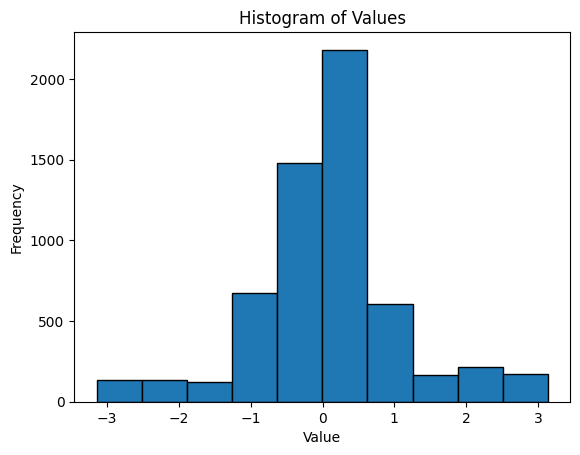

In [6]:
import matplotlib.pyplot as plt
plt.hist(np.array(goals)[:,1], bins=10, edgecolor='black')  # Adjust the number of bins as necessary
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()
